### Setup Environment:

In [36]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models

# ResNet-50 모델 불러오기
resnet50 = models.resnet50(pretrained=True)

# 모델 구조 출력
print(resnet50)
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np 
from sklearn import datasets


# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
from src.test import test

In [38]:
# Constants:
DATASET = 'data'
DOWNLOAD = False
SHAPE = (224, 224)
LABEL = 'DR_ICDR'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'resnet50'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 32
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

if torch.backends.mps.is_available():
    device  = torch.device("mps")
    IMAGES = os.path.join('a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos')

elif torch.cuda.is_available():
    device = torch.device('cuda')
    IMAGES = os.path.join(r'data\fundus_photos')


print(device)

cuda


#### Read csv file:

In [39]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in data/labels.csv


,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal


In [40]:
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else 'Diabetic Retinopathy')

normal_df = df[df['DR_ICDR'] == 'Normal']

print(len(normal_df))
diabetic_df = df[df['DR_ICDR'] == 'Diabetic Retinopathy']

# 'Normal' 데이터에서 무작위로 1056개 샘플을 선택
normal_downsampled = normal_df.sample(n=1056, random_state=42)  # random_state는 결과의 재현성을 위함

# 다운샘플링된 'Normal' 데이터와 모든 'Diabetic Retinopathy' 데이터를 합치기
balanced_df = pd.concat([normal_downsampled, diabetic_df])

# 결과 확인
print(balanced_df['DR_ICDR'].value_counts())


print(len(df[df['DR_SDRG']==0]))
print(len(df[df['DR_SDRG']!=0]))
print(len(df[df['DR_ICDR']=='Normal']))
print(len(df[df['DR_ICDR']!='Normal']))

15210
DR_ICDR
Normal                  1056
Diabetic Retinopathy    1056
Name: count, dtype: int64
15212
1054
15210
1056


In [41]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(balanced_df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

Train data shape: (1478, 35)
Test data shape: (634, 35)
Getting validation set...
Train data shape: (507, 35)
Test data shape: (127, 35)


In [42]:
def balance_classes(data, label_column):
    # 클래스 별로 데이터를 그룹화
    min_count = data[label_column].value_counts().min()
    # 각 클래스에서 min_count만큼 샘플링
    balanced_data = data.groupby(label_column).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
    
    return balanced_data


In [43]:
balanced_df = balanced_df[['image_id', 'DR_ICDR']]
balanced_df

,image_id,DR_ICDR
1207,img01208,Normal
10823,img10824,Normal
9371,img09372,Normal
9397,img09398,Normal
14584,img14585,Normal
...,...,...
16242,img16243,Diabetic Retinopathy
16243,img16244,Diabetic Retinopathy
16244,img16245,Diabetic Retinopathy
16260,img16261,Diabetic Retinopathy


In [44]:
# 레이블된 데이터의 비율 설정
label_ratio_50 = 0.3
label_ratio_25 = 0.2
label_ratio_12_5 = 0.1

def get_data(frac):
    normal_df = balanced_df[balanced_df['DR_ICDR']=='Normal']
    DR_df = balanced_df[balanced_df['DR_ICDR']=='Diabetic Retinopathy']
    DR_labeled_data = DR_df.sample(frac=frac, random_state=42)
    normal_labeled_data = normal_df.sample(frac=frac, random_state=42)
    labeled_data = pd.concat([DR_labeled_data, normal_labeled_data])
    unlabeled_data = balanced_df.drop(labeled_data.index)
    return labeled_data, unlabeled_data

labeled_data_50, unlabeled_data_50 = get_data(label_ratio_50)
labeled_data_25, unlabeled_data_25 = get_data(label_ratio_25)
labeled_data_12_5, unlabeled_data_12_5 = get_data(label_ratio_12_5)

# 결과 출력
print("Labeled data (50%):", len(labeled_data_50))
print("Unlabeled data (50%):", len(unlabeled_data_50))
print("Labeled data (25%):", len(labeled_data_25))
print("Unlabeled data (25%):", len(unlabeled_data_25))

df_train, df_test = split_data(balanced_df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)


df_train50, df_test50 = split_data(labeled_data_50, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test50, df_val50 = split_data(df_test50, LABEL, 0.20)

df_train25, df_test25 = split_data(labeled_data_25, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test25, df_val25 = split_data(df_test25, LABEL, 0.20)

df_train12_5, df_test12_5 = split_data(labeled_data_12_5, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test12_5, df_val12_5 = split_data(df_test12_5, LABEL, 0.20)

Labeled data (50%): 634
Unlabeled data (50%): 1478
Labeled data (25%): 422
Unlabeled data (25%): 1690
Train data shape: (1478, 2)
Test data shape: (634, 2)
Getting validation set...
Train data shape: (507, 2)
Test data shape: (127, 2)
Train data shape: (443, 2)
Test data shape: (191, 2)
Getting validation set...
Train data shape: (152, 2)
Test data shape: (39, 2)
Train data shape: (295, 2)
Test data shape: (127, 2)
Getting validation set...
Train data shape: (101, 2)
Test data shape: (26, 2)
Train data shape: (148, 2)
Test data shape: (64, 2)
Getting validation set...
Train data shape: (51, 2)
Test data shape: (13, 2)


### Dataloaders

In [45]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [46]:
labeled_data_12_5['DR_ICDR']

3137     Diabetic Retinopathy
11595    Diabetic Retinopathy
11891    Diabetic Retinopathy
15465    Diabetic Retinopathy
854      Diabetic Retinopathy
                 ...         
6969                   Normal
6236                   Normal
7172                   Normal
5866                   Normal
11402                  Normal
Name: DR_ICDR, Length: 212, dtype: object

In [47]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [48]:
# Create the custom dataset
def get_dataset(df_labeled, df_unlabeled, df_test, df_val):
    labeled_dataset = BRSETDataset(
        df_labeled, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=train_transforms
    )

    unlabeled_dataset = BRSETDataset(
        df_unlabeled, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=train_transforms  # You may need different transformations for unlabeled data
    )

    test_dataset = BRSETDataset(
        df_test, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=test_transform
    )

    val_dataset = BRSETDataset(
        df_val, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=test_transform
    )
    labeled_dataloader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    
    return labeled_dataloader, unlabeled_dataloader, test_dataloader, val_dataloader



train_dataloader, _, test_dataloader, val_dataloader = get_dataset(df_train, df_train, df_test, df_val)
train_dataloader50, unlabeled_dataloader50, test_dataloader50, val_dataloader50 = get_dataset(df_train50, unlabeled_data_50, df_test50, df_val50)
train_dataloader25, unlabeled_dataloader25, test_dataloader25, val_dataloader25 = get_dataset(df_train25, unlabeled_data_25, df_test25, df_val25)
train_dataloader12_5, unlabeled_dataloader12_5, test_dataloader12_5, val_dataloader12_5 = get_dataset(df_train12_5, unlabeled_data_12_5, df_test12_5, df_val12_5)


In [49]:
def get_dataset_not_loader(df_labeled, df_unlabeled, df_test, df_val):
    labeled_dataset = BRSETDataset(
        df_labeled, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=train_transforms
    )

    unlabeled_dataset = BRSETDataset(
        df_unlabeled, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=train_transforms  # You may need different transformations for unlabeled data
    )

    test_dataset = BRSETDataset(
        df_test, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=test_transform
    )

    val_dataset = BRSETDataset(
        df_val, 
        IMAGE_COL, 
        IMAGES, 
        LABEL, 
        mlb, 
        train_columns, 
        transform=test_transform
    )

    return labeled_dataset, unlabeled_dataset, test_dataset, val_dataset

train_dataset, _, test_dataset, val_dataset = get_dataset_not_loader(df_train, df_train, df_test, df_val)
train_dataset50, unlabeled_dataset50, test_dataset50, val_dataset50 = get_dataset_not_loader(df_train50, unlabeled_data_50, df_test50, df_val50)
train_dataset25, unlabeled_dataset25, test_dataset25, val_dataset25 = get_dataset_not_loader(df_train25, unlabeled_data_25, df_test25, df_val25)
train_dataset12_5, unlabeled_dataset12_5, test_dataset12_5, val_dataset12_5 = get_dataset_not_loader(df_train12_5, unlabeled_data_12_5, df_test12_5, df_val12_5)


In [50]:
# # Print 6 samples with their labels
# # Iterate through the DataLoader and plot the images with labels
# for batch in train_dataloader:
#     images, labels = batch['image'], batch['labels']

#     for i in range(len(images)):
#         if i == 6:
#             break
#         plt.subplot(2, 3, i + 1)
#         plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
#         plt.title(f"Label: {labels[i]}")
#         plt.axis('off')
#     plt.show()
#     break

### Model

In [51]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [52]:
def setting(train_dataloader):
    if LOSS == 'focal_loss':
        class_distribution = train_dataloader.dataset.labels.sum(axis=0)
        print(f'Class distribution: {class_distribution}')
        class_dis = np.array(class_distribution)
        class_weights =1-class_dis/np.sum(class_dis)
        weights = torch.tensor(class_weights).to(device)
        #criterion = FocalLoss()  # Focal Loss
        criterion = FocalLoss(gamma=2, alpha=weights)
        class_indices = None
    else:
        class_distribution = None
        class_dis = None
        # Assuming train_loader.dataset.labels is a one-hot representation
        class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)
        # Compute class weights using class indices
        class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
        class_weights = torch.tensor(class_weights, dtype=torch.float32)
        criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
        weights = None
        #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

    if OPTIMIZER == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif OPTIMIZER == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    return class_distribution,class_dis,class_weights,weights,criterion,class_indices,optimizer

### Image quality assessment

In [53]:
def mean_teacher(l_x, u_x, epochs):
    teacher = models.resnet50(pretrained=False,num_classes=2).cuda()
    student = models.resnet50(pretrained=False,num_classes=2).cuda()

    t_optimizer = optim.SGD(teacher.parameters(), lr=0.001, momentum=0.9)
    s_optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9)
    
    for iteration in range(epochs):
        teacher.train()
        student.train()
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()
        for i in range(len(l_x)):
            inputs = l_x.__getitem__(i)['image'].cuda()
            inputs = inputs.unsqueeze(0).cuda()

            labels = l_x.__getitem__(i)['labels'].cuda()
            labels = labels.unsqueeze(0).cuda()  
            t_l_logit = teacher(inputs)
            t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, labels)

            t_l_loss.backward()
            t_optimizer.step()
            
        for i in range(len(u_x)):
            inputs = u_x.__getitem__(i)['image'].cuda()
            inputs = inputs.unsqueeze(0).cuda()

            with torch.no_grad():
                t_u_logit = teacher(inputs)
                pseudo_y = torch.sigmoid(t_u_logit) 
            
            s_u_logit = student(inputs)
            s_u_loss = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y, reduction='mean')
            s_u_loss.backward()
            s_optimizer.step()

        print('Epoch {}/{} completed'.format(iteration+1, 100))

    return student


In [57]:
def meta_pseudo_label(l_x, u_x, epochs):    
    device = torch.device('cuda')
    teacher = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=2, mode=MODE, backbone_mode=backbone_mode)
    student = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=2, mode=MODE, backbone_mode=backbone_mode)
    teacher.to(device)
    student.to(device)

    t_optimizer = optim.SGD(teacher.parameters(), lr=0.001, momentum=0.9)
    s_optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9)
    
    for iteration in range(epochs):
        teacher.train()
        student.train()
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()        
        for i in range(len(u_x)):
            inputs = u_x.__getitem__(i)['image'].cuda()
            inputs = inputs.unsqueeze(0).cuda()

            with torch.no_grad():
                t_u_logit = teacher(inputs)
                pseudo_y = torch.sigmoid(t_u_logit) 
            
            s_u_logit = student(inputs)
            s_u_loss = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y, reduction='none')
            s_u_loss = s_u_loss[torch.abs(pseudo_y - 0.5) > 0.45].mean()
            s_u_loss.backward()
            s_optimizer.step()

        for i in range(len(l_x)):
            inputs = l_x.__getitem__(i)['image'].cuda()
            inputs = inputs.unsqueeze(0).cuda()

            labels = l_x.__getitem__(i)['labels'].cuda()
            labels = labels.unsqueeze(0).cuda()  


            s_l_logit_new = student(inputs)
            s_l_loss_new = F.binary_cross_entropy_with_logits(s_l_logit_new, labels)
            t_mpl_loss = s_l_loss_new

            t_l_logit = teacher(inputs)
            t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, labels)

            (t_l_loss + t_mpl_loss).backward()
            t_optimizer.step()
            
        print('Epoch {}/{} completed'.format(iteration+1, 100))

    return student

In [58]:
# epochs = 1
# mean_student_10 = mean_teacher(train_dataset12_5, unlabeled_dataset12_5, epochs)


In [59]:
epochs = 100
meta_student_10 = meta_pseudo_label(train_dataset12_5, unlabeled_dataset12_5, epochs)
meta_student_20 = meta_pseudo_label(train_dataset25, unlabeled_dataset25, epochs)
meta_student_30 = meta_pseudo_label(train_dataset50, unlabeled_dataset50, epochs)

# mean_student_10 = mean_teacher(train_dataset12_5, unlabeled_dataset12_5, epochs)
# mean_student_20 = mean_teacher(train_dataset25, unlabeled_dataset25, epochs)
# mean_student_30 = mean_teacher(train_dataset50, unlabeled_dataset50, epochs)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# for batch in test_dataloader25:
#     image, labels =  batch['image'].to(device), batch['labels'].to(device)
#     # print(image, labels)
#     # 모델에 이미지를 전달하여 출력 예측
#     outputs = model(image)
    
#     # 출력에 NaN 값이 있는지 확인
#     if torch.isnan(outputs).any():
#         print("NaN 값이 발생했습니다.")


In [ ]:
# torch.save(meta_student_10.state_dict(), './model/meta_student_10.pth')
# torch.save(meta_student_20.state_dict(), './model/meta_student_20.pth')
# torch.save(meta_student_30.state_dict(), './model/meta_student_30.pth')

In [ ]:
meta_student_10 = models.resnet50(pretrained=False ,num_classes=2).cuda()  
meta_student_10.load_state_dict(torch.load("./model/meta_student_10.pth"))

meta_student_20 = models.resnet50(pretrained=False ,num_classes=2).cuda()
meta_student_20.load_state_dict(torch.load("./model/meta_student_20.pth"))

meta_student_30 = models.resnet50(pretrained=False ,num_classes=2).cuda()
meta_student_30.load_state_dict(torch.load("./model/meta_student_30.pth"))


<All keys matched successfully>

100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


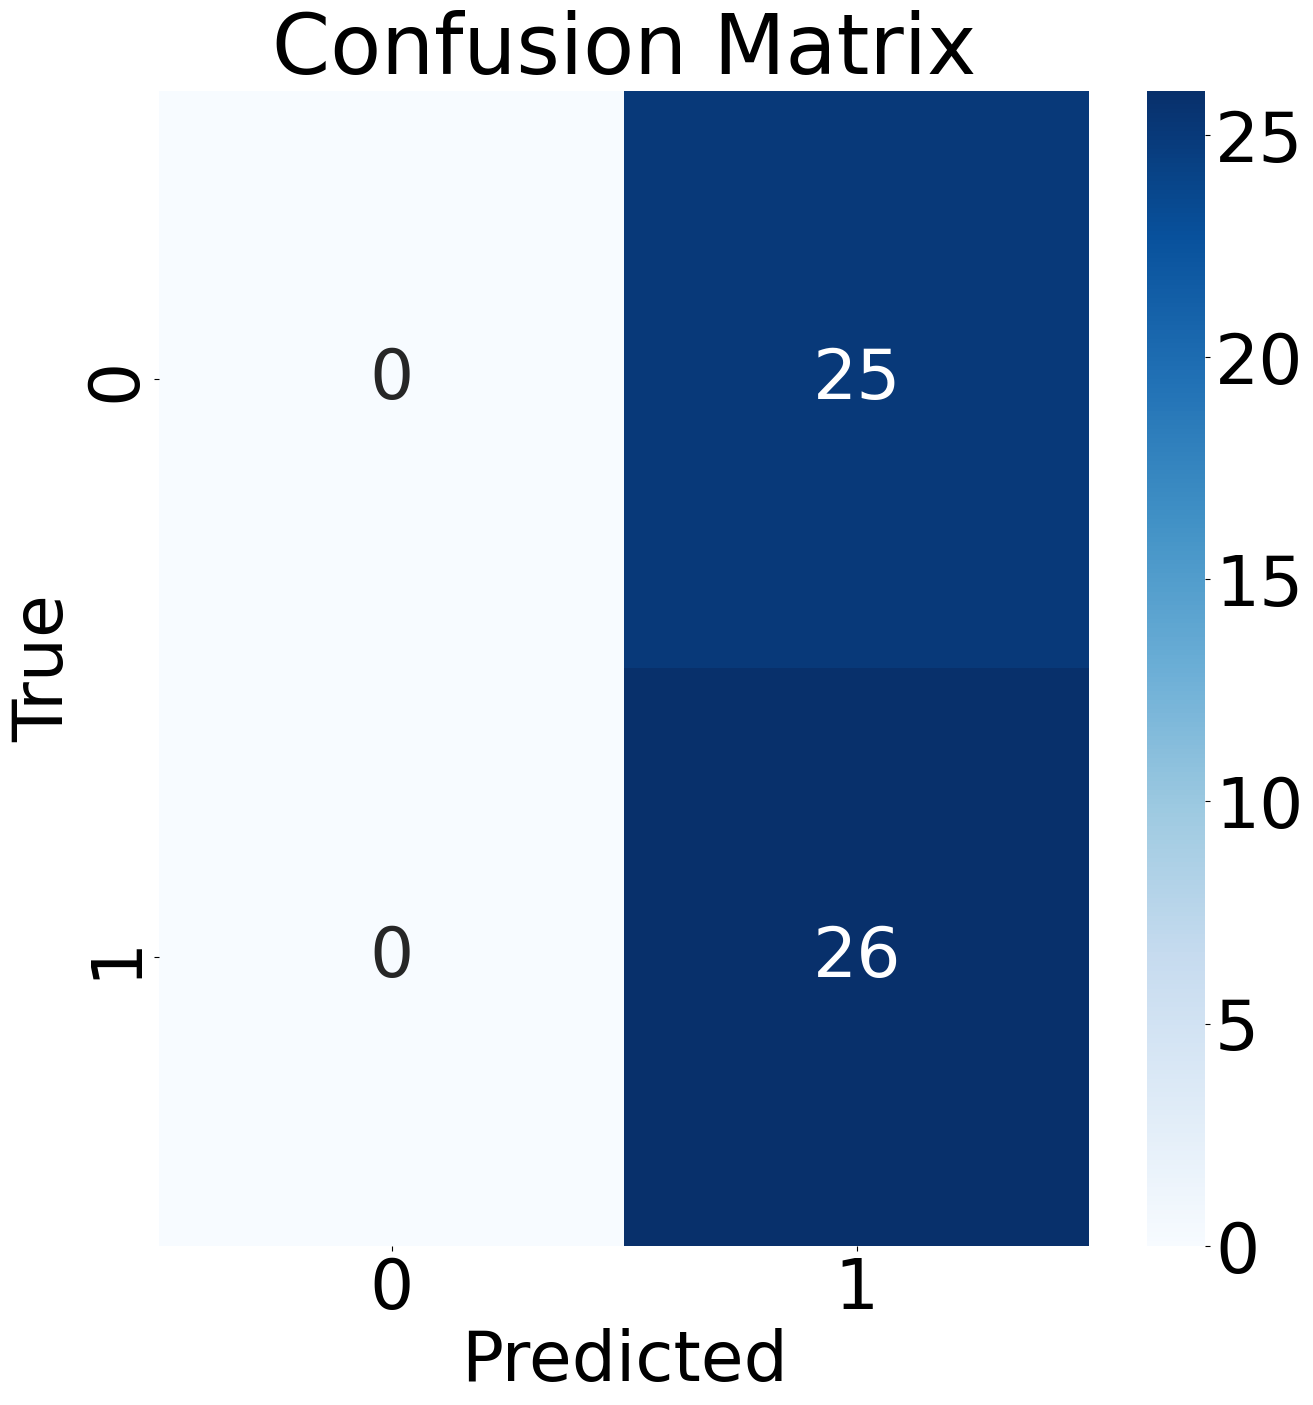

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.51      1.00      0.68        26

    accuracy                           0.51        51
   macro avg       0.25      0.50      0.34        51
weighted avg       0.26      0.51      0.34        51

##################################################  Saliency Maps  ##################################################

Class 0:


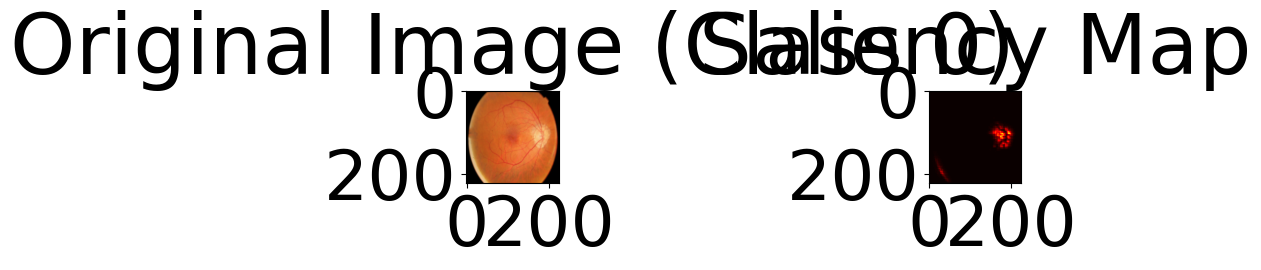

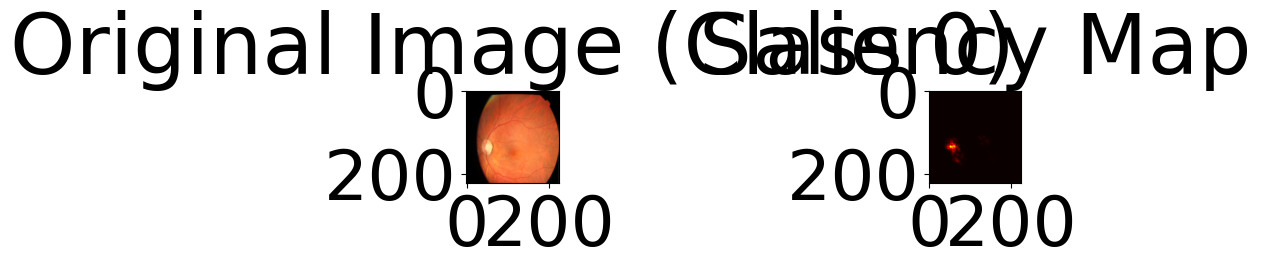

Class 1:


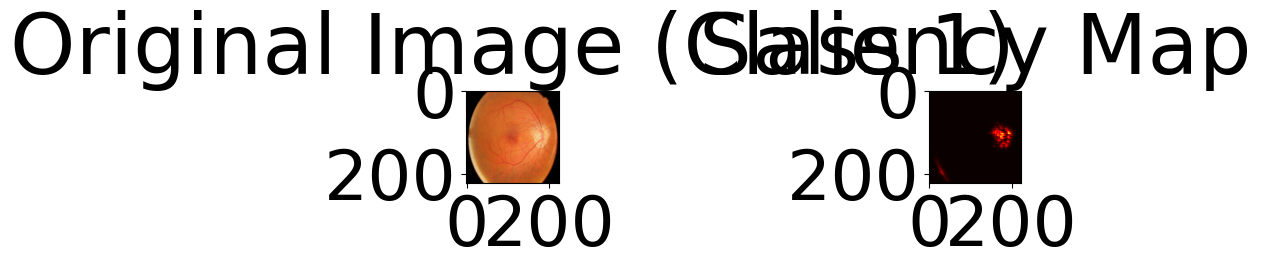

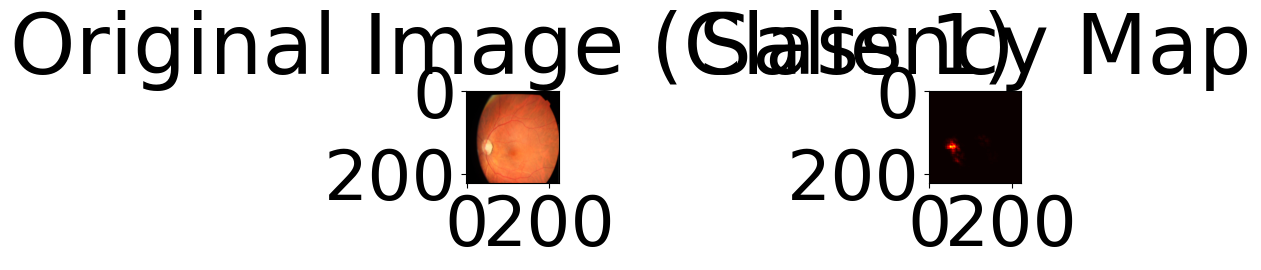

100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


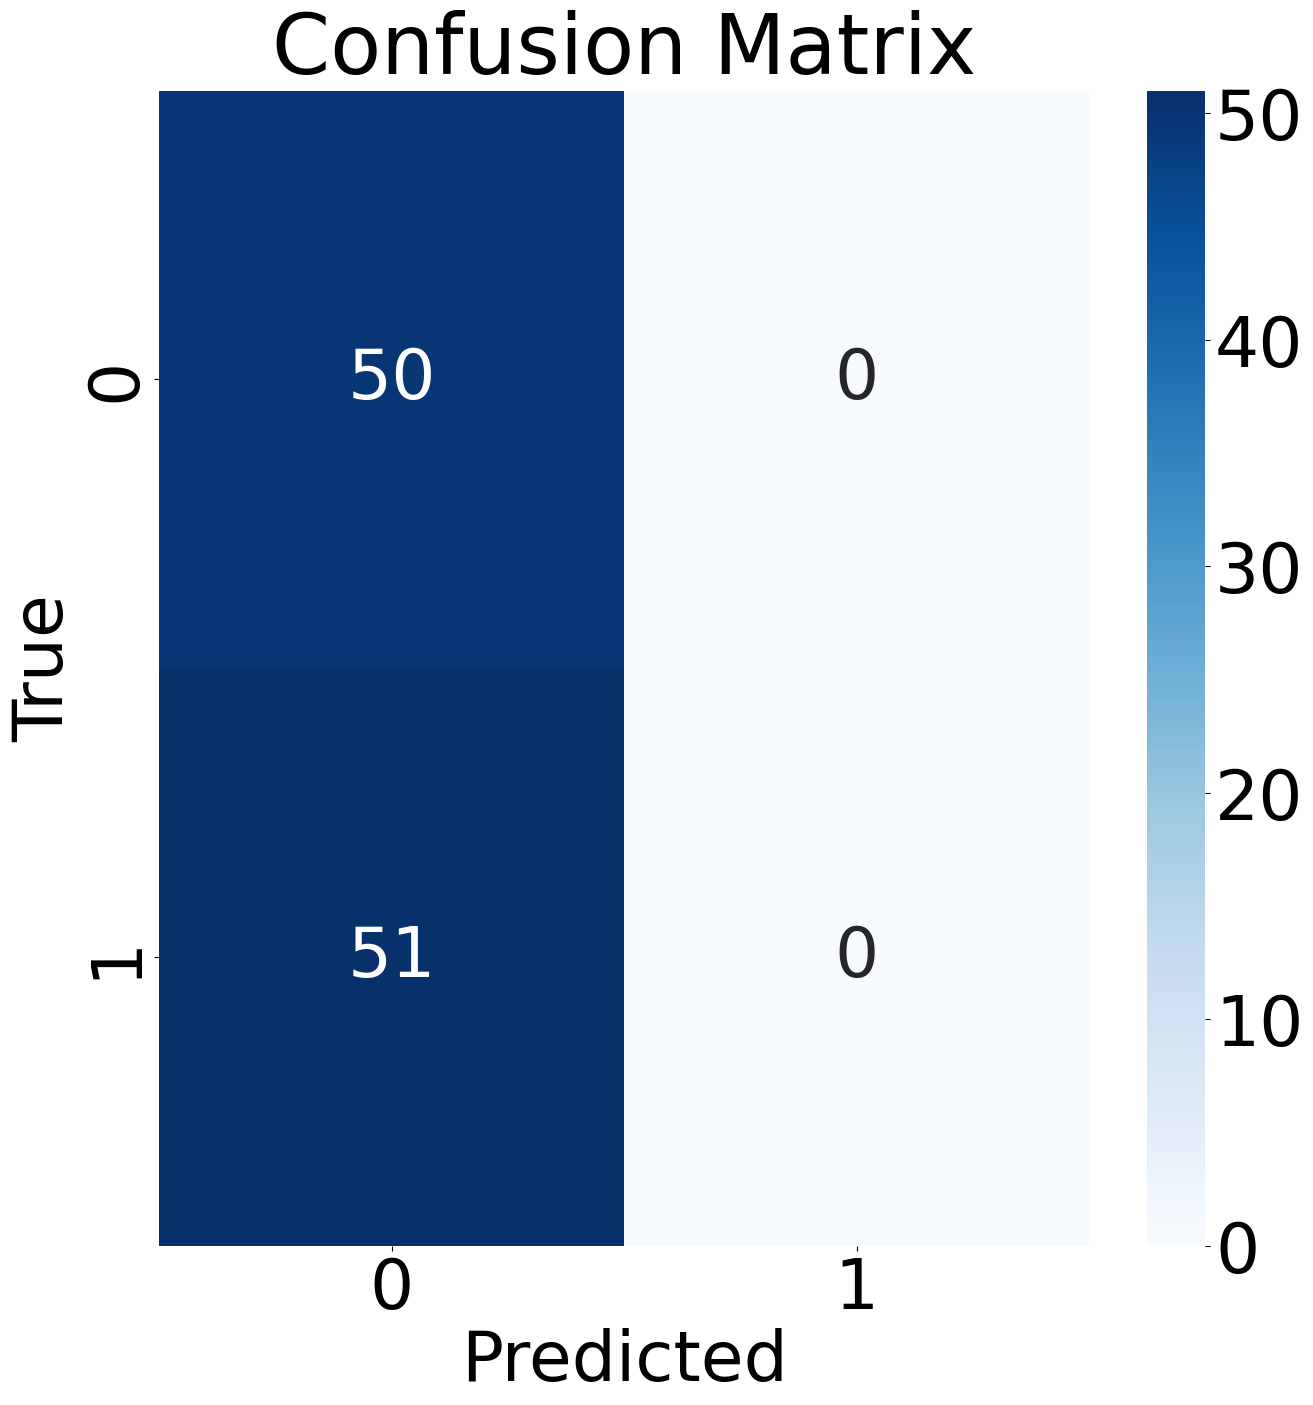

              precision    recall  f1-score   support

           0       0.50      1.00      0.66        50
           1       0.00      0.00      0.00        51

    accuracy                           0.50       101
   macro avg       0.25      0.50      0.33       101
weighted avg       0.25      0.50      0.33       101

##################################################  Saliency Maps  ##################################################

Class 0:


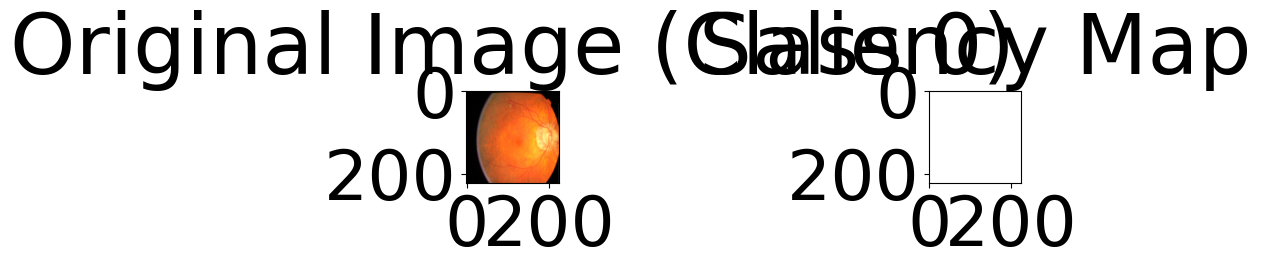

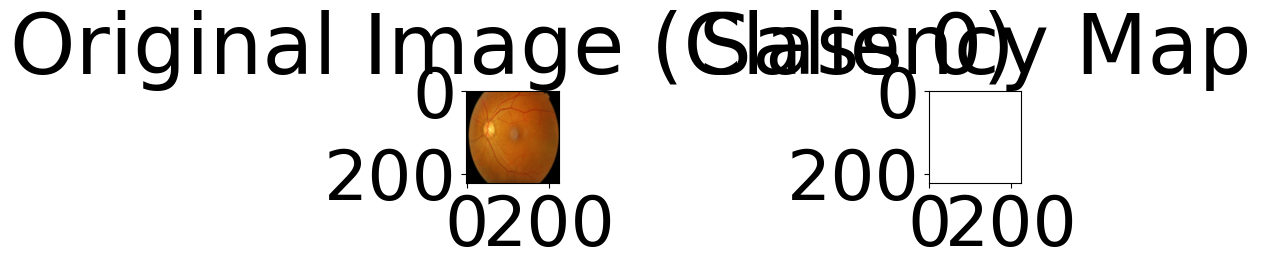

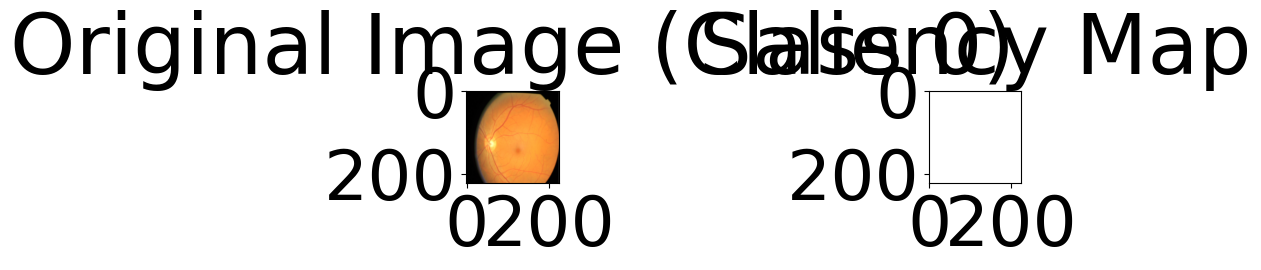

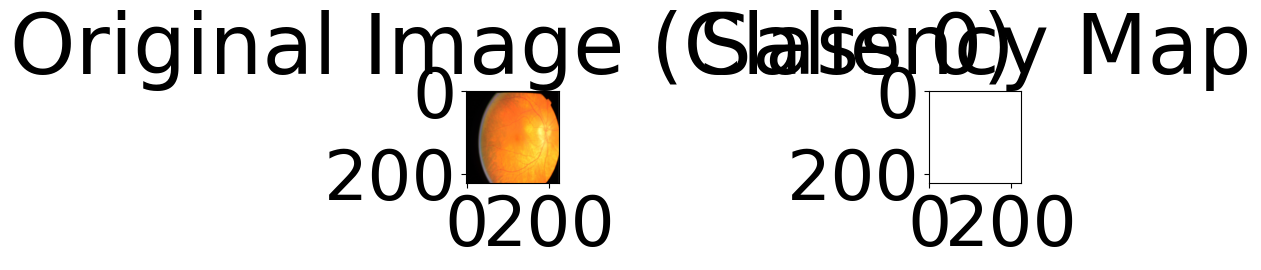

Class 1:


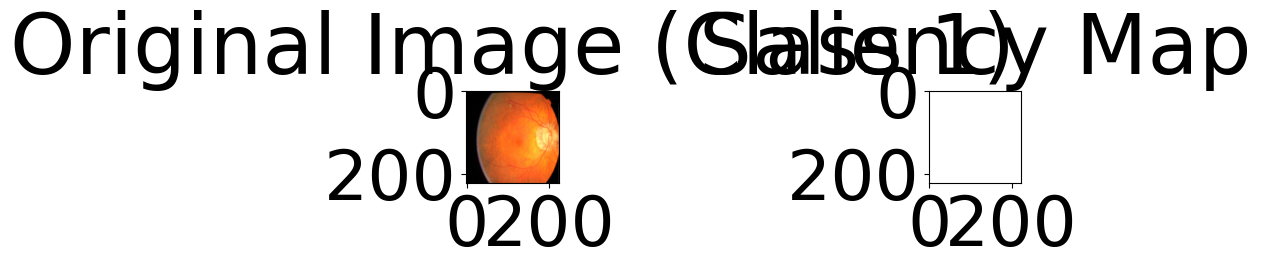

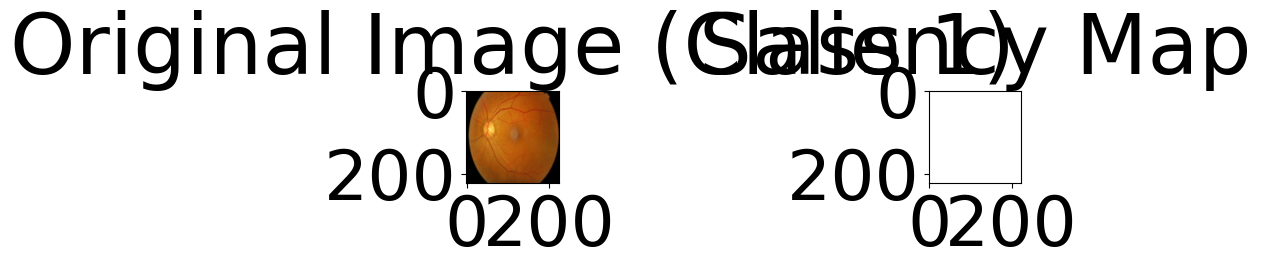

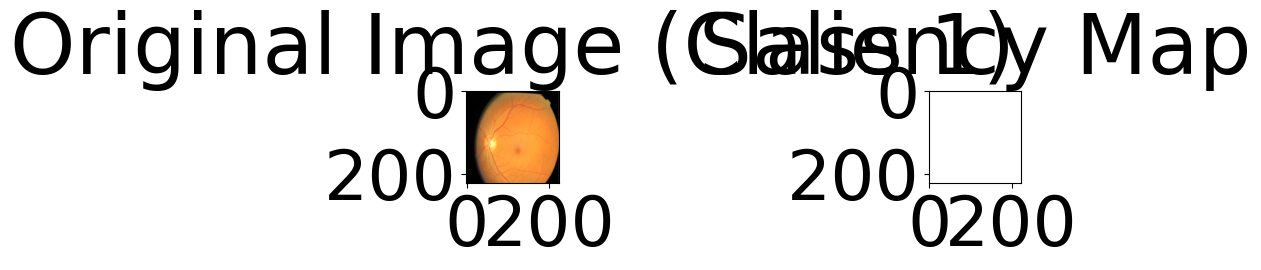

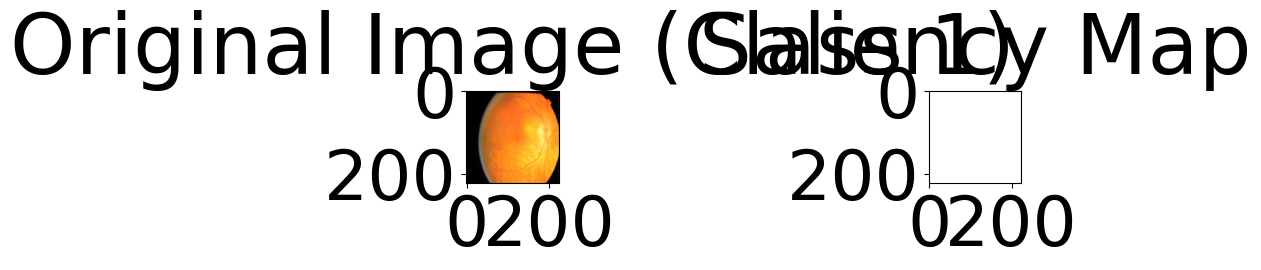

100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


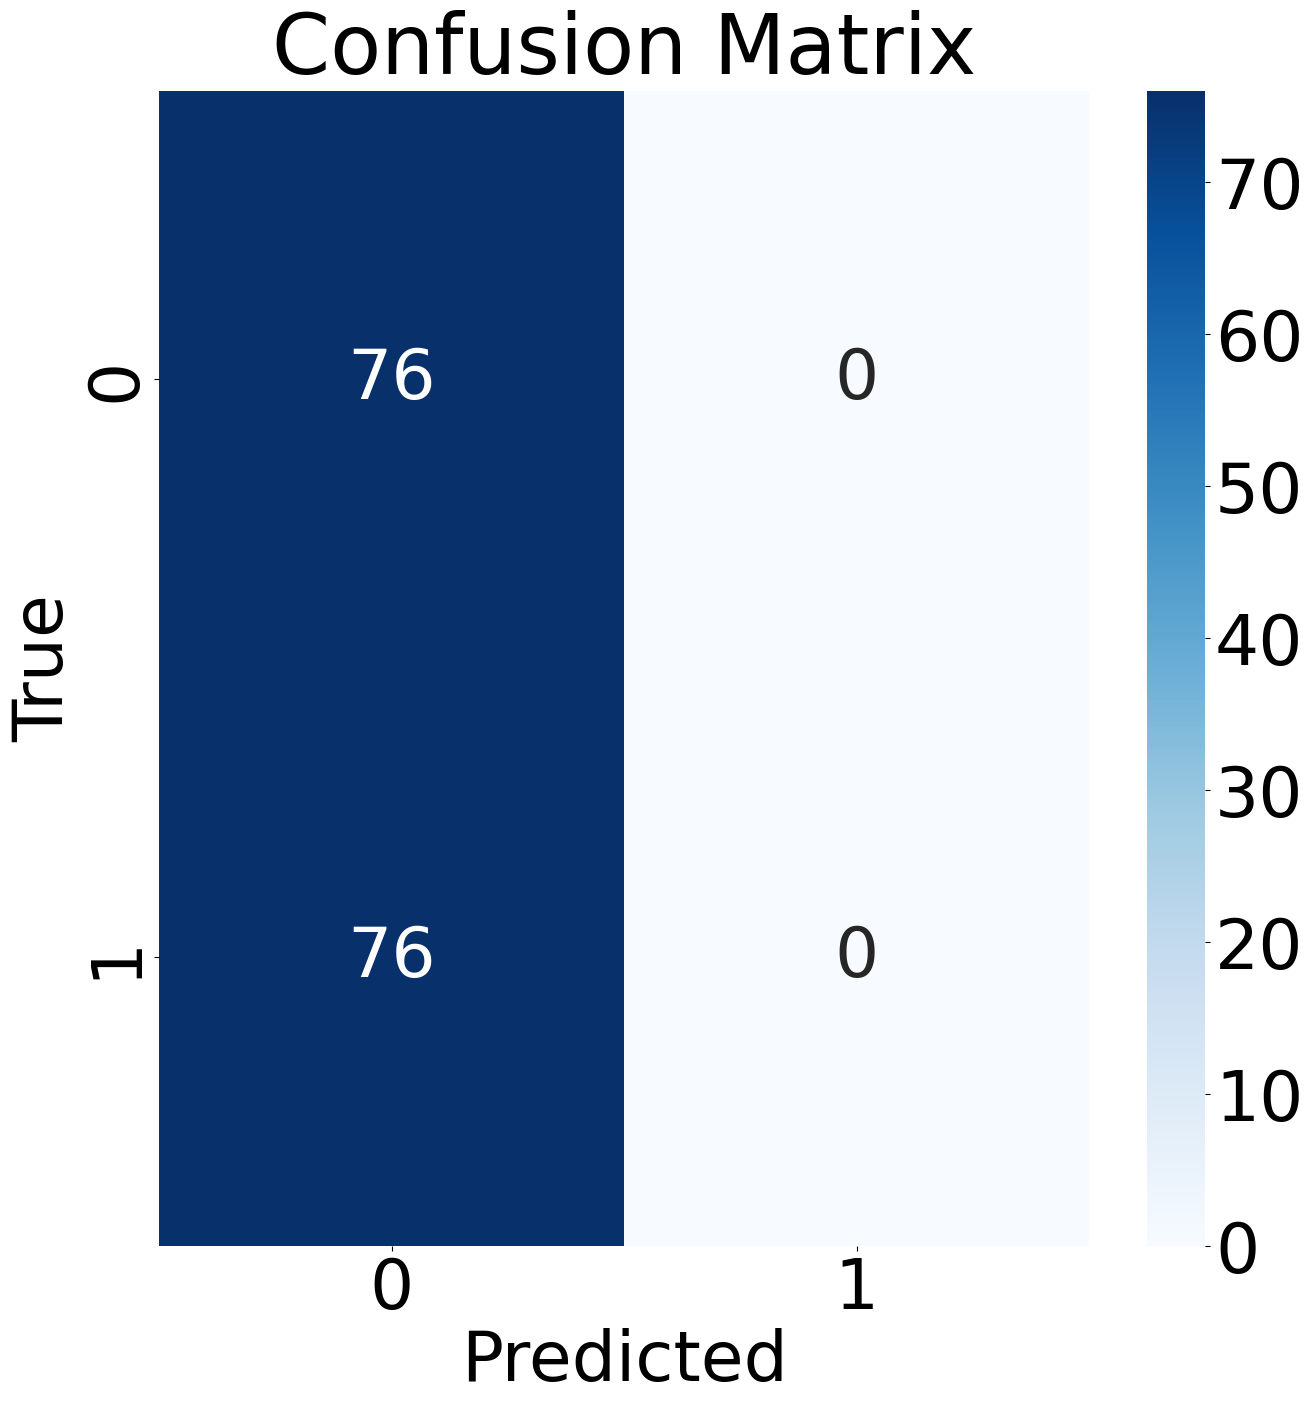

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        76
           1       0.00      0.00      0.00        76

    accuracy                           0.50       152
   macro avg       0.25      0.50      0.33       152
weighted avg       0.25      0.50      0.33       152

##################################################  Saliency Maps  ##################################################

Class 0:


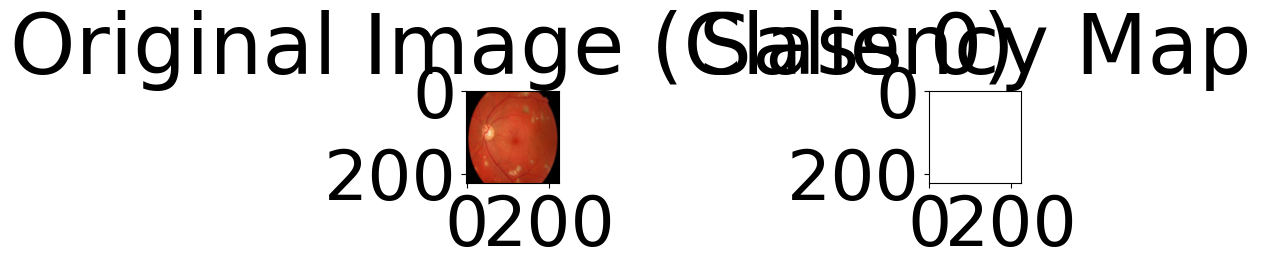

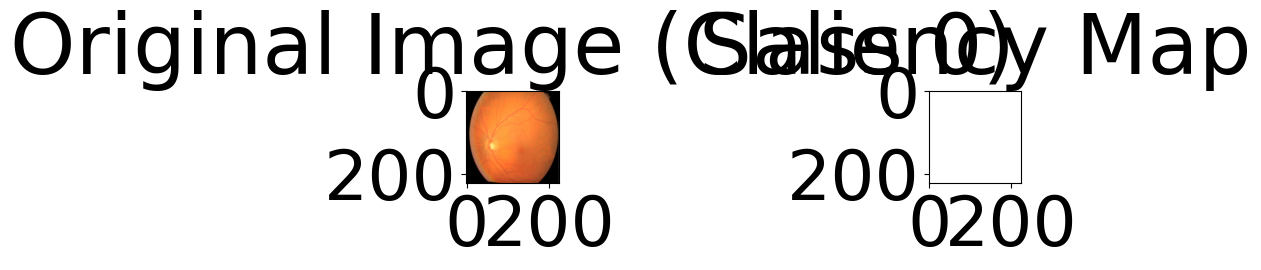

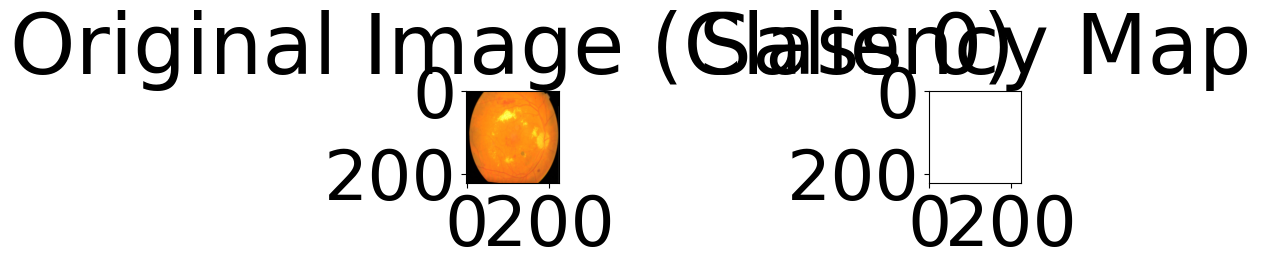

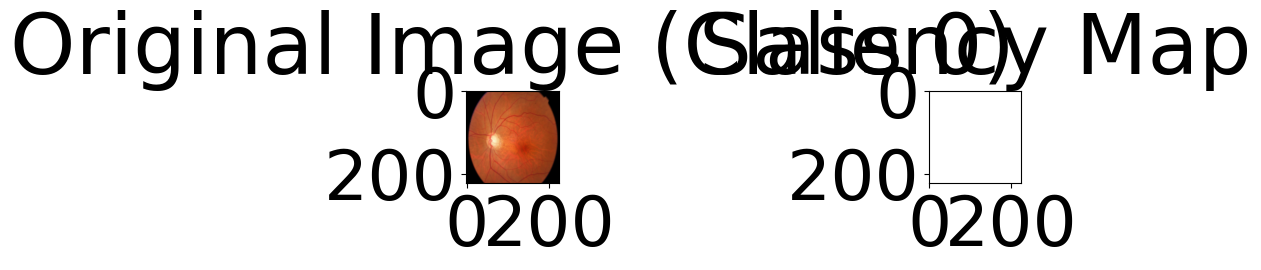

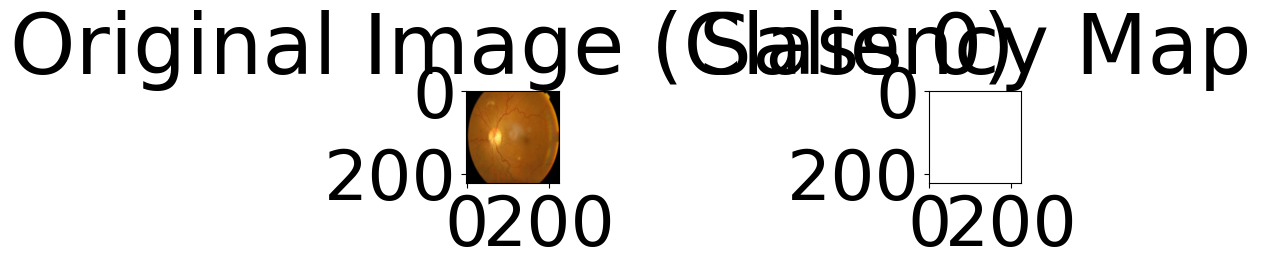

Class 1:


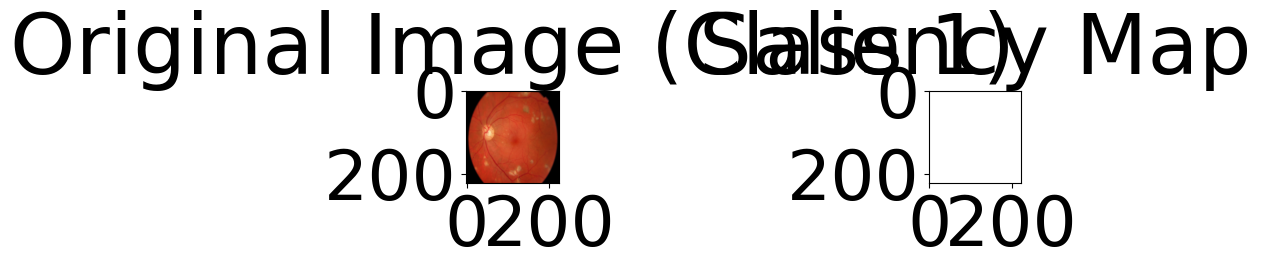

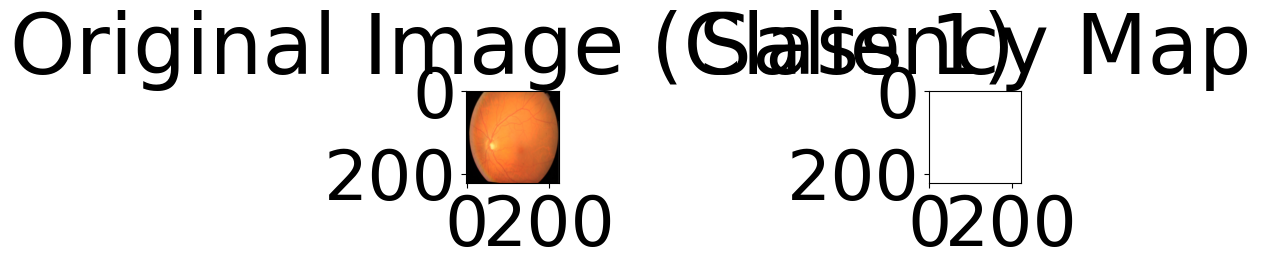

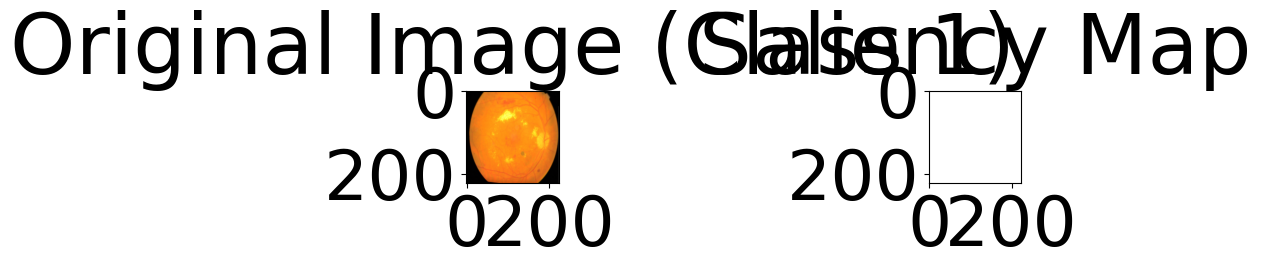

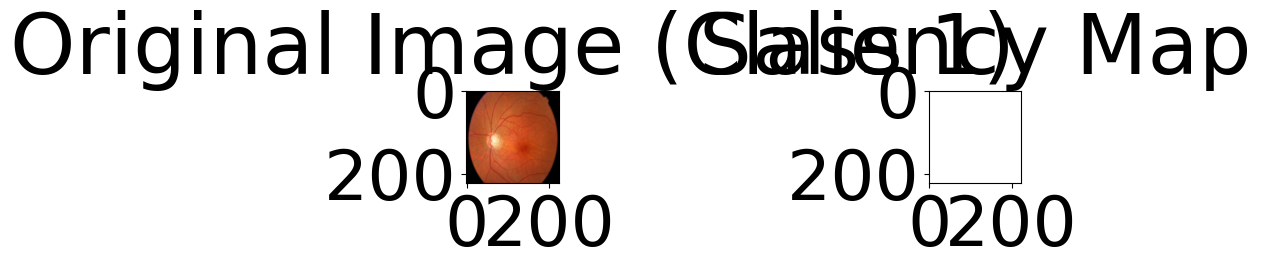

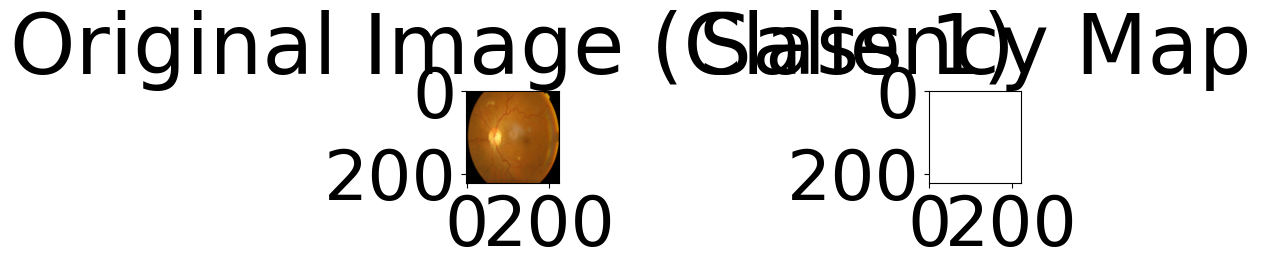

In [ ]:
test(meta_student_10, test_dataloader12_5, saliency=True, device=device)
test(meta_student_20, test_dataloader25, saliency=True, device=device)
test(meta_student_30, test_dataloader50, saliency=True, device=device)